Decision Tree

In [23]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


Read Data

In [24]:
import numpy as np
import pandas as pd
import math
import re

from matplotlib import pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


df_train = pd.read_csv('data/train.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
df_train_label = df_train[["Id", "SalePrice"]]
df_train = df_train.drop('SalePrice', axis=1)

df_train = df_train.set_index("Id")
df_train_label = df_train_label.set_index("Id")

df_test = pd.read_csv('data/test.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')

test_null_columns=df_test.columns[df_test.isnull().any()] 
train_null_columns=df_train.columns[df_train.isnull().any()] 
test_null_only_ColIdx = test_null_columns.difference(train_null_columns)

test_null_only_RowIdx = [ df_test[df_test[idx].isnull()].index.tolist() for idx in test_null_only_ColIdx ]
test_null_only_RowIdx = list ( set(x for l in test_null_only_RowIdx for x in l) )

problematicTestSet = df_test.loc[ df_test.index.isin( test_null_only_RowIdx ) ]

fineTestSet = df_test.loc[ ~df_test.index.isin( test_null_only_RowIdx ) ]  #1447 records

problematicTestSet= problematicTestSet.set_index("Id")
fineTestSet = fineTestSet.set_index("Id")
df_test = df_test.set_index("Id")

df = pd.concat([df_train,df_test], axis=0, sort=True)

problematicTestSet.index

Int64Index([1556, 1916, 1946, 2121, 2152, 2189, 2217, 2251, 2474, 2490, 2577, 2905], dtype='int64', name='Id')

Impute Data with preprocess.py subfunction

In [25]:
from preprocess import impute
#label encode
#df_label_count, encodedDic = impute( df, False) 
#df_test = df_label_count[df_label_count.index >= min(df_test.index)]
#df_train = df_label_count[df_label_count.index < min(df_test.index)]
#onehot encode
df_onehot, _ = impute( df, True) 
df_test = df_onehot[df_onehot.index >= min(df_test.index)]
df_train = df_onehot[df_onehot.index < min(df_test.index)]

In [26]:
df_train_label = df_train_label.astype(int)
df_train_label_log = np.log( df_train_label )
#df_train_label.hist()
#df_train_label_log.hist()

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_train, df_train_label_log, test_size=0.2, random_state=0)

In [28]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

#of instances per leaf = 5
regression_model = DecisionTreeRegressor(criterion="mse", min_samples_leaf=5, random_state=0) 
cvrmse = np.sqrt(-cross_val_score( regression_model, df_train, df_train_label_log, scoring="neg_mean_squared_error", cv = 10) )
print( cvrmse.mean() )
print( cvrmse.std() )
cvrmse

0.18484485050148983
0.02340458815313157


array([0.18698451, 0.16169606, 0.19361378, 0.23949329, 0.20520328,
       0.17610829, 0.15817062, 0.17109899, 0.19200557, 0.1640741 ])

In [29]:
def evaluate(model, test_features, test_labels): 
    
    predictions = model.predict(test_features).ravel() 
    residuals = test_labels - predictions
    
    rmse = np.sqrt(np.mean((test_labels - predictions) ** 2))
    
    rmsle = np.sqrt(np.mean((np.log1p(predictions) - np.log1p(test_labels))**2)) 
    
    pred = pd.DataFrame( {'residuals': residuals.values, 'predictions': predictions} )
    pred.set_index(residuals.index)
    
    return [rmse, rmsle, pred]

In [30]:
# Fit the Decision Tree model
dt = regression_model.fit(df_train, df_train_label_log)


RMSE = 0.1081
RMSLE = 0.0083


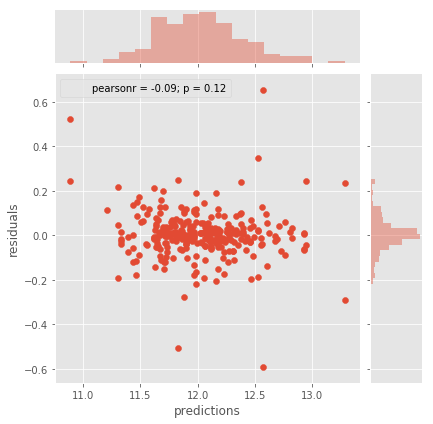

In [31]:
rmse, rmsle, pred = evaluate(dt, X_test, y_test['SalePrice'] )
print('RMSE = {:0.4f}'.format(rmse))
print('RMSLE = {:0.4f}'.format(rmsle))
sns.jointplot(x = "predictions", y = "residuals",  data=pred )

In [32]:
d = {  'SalePrice': np.expm1 ( dt.predict(df_test) )    }
sub = pd.DataFrame(data = d, dtype=np.int64, index = df_test.index )
sub.to_csv('tree.csv')

In [28]:
import pickle
with open('tree.pkl', 'wb') as handle:
    pickle.dump(dt, handle, protocol=pickle.HIGHEST_PROTOCOL)